# DA3 Assignment 3
## Finding fast growing firms 2025
### Carsen Essing, Artem Bilko


In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Core system and OS utilities
import os
import sys

# Core data analysis libraries
import pandas as pd
import numpy as np

# Plotting and visualization
from plotnine import (
    ggplot, aes, geom_point, geom_smooth, labs,
    scale_x_continuous, scale_y_continuous, theme_bw
)
import matplotlib.pyplot as plt

# Statistical modeling
import statsmodels.formula.api as smf
from skmisc.loess import loess

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Model evaluation
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
)
from sklearn.metrics import (
    accuracy_score, roc_auc_score, mean_squared_error, r2_score,
    confusion_matrix, ConfusionMatrixDisplay
)



## Data Management

The data cleaning procedure builds upon the foundation provided in the script `ch17-firm-exit-data-prep`. Key modifications were made to extend the temporal coverage of the panel dataset to include the years 2012 and 2013. This extension was essential to enable the construction of the target variablel **fast growth** which is defined based on firm performance over either a one-year (2013 vs. 2012) or two-year (2014 vs. 2012) horizon.


In [2]:
# Load required libraries
import pandas as pd

# Load the dataset
url = "https://raw.githubusercontent.com/CarsenEssing/ML-Assignment-3/main/cs_bisnode_panel.zip"
data = pd.read_csv(url, compression="zip")

# Display initial shape and columns
print("Initial dataset shape:", data.shape)
print("Columns:\n", data.columns.tolist())

# Filter for relevant years: 2010–2015
data = data.query("2010 <= year <= 2015").copy()
print("After filtering for years 2010-2015:", data.shape)

# Drop columns with many missing values (manual selection)
cols_to_drop = [
    "COGS", "finished_prod", "net_dom_sales", "net_exp_sales", "wages"
]
data.drop(columns=cols_to_drop, inplace=True)

# Check missingness after dropping
missing_summary = data.isnull().mean().sort_values(ascending=False)
print("Top 10 columns with missing values:\n", missing_summary.head(10))


Initial dataset shape: (287829, 48)
Columns:
 ['comp_id', 'begin', 'end', 'COGS', 'amort', 'curr_assets', 'curr_liab', 'extra_exp', 'extra_inc', 'extra_profit_loss', 'finished_prod', 'fixed_assets', 'inc_bef_tax', 'intang_assets', 'inventories', 'liq_assets', 'material_exp', 'net_dom_sales', 'net_exp_sales', 'personnel_exp', 'profit_loss_year', 'sales', 'share_eq', 'subscribed_cap', 'tang_assets', 'wages', 'D', 'balsheet_flag', 'balsheet_length', 'balsheet_notfullyear', 'year', 'founded_year', 'exit_year', 'ceo_count', 'foreign', 'female', 'birth_year', 'inoffice_days', 'gender', 'origin', 'nace_main', 'ind2', 'ind', 'urban_m', 'region_m', 'founded_date', 'exit_date', 'labor_avg']
After filtering for years 2010-2015: (167606, 48)
Top 10 columns with missing values:
 D               1.000000
exit_year       0.898822
exit_date       0.877457
labor_avg       0.318282
birth_year      0.257873
founded_year    0.109835
gender          0.109799
foreign         0.109799
female          0.10979

In [3]:
# Drop 'D' column as it contains only missing values
if 'D' in data.columns:
    data.drop(columns=['D'], inplace=True)


## Label engineering

In [4]:
# Ensure full (year, comp_id) panel: insert missing year-firm combos
data = (
    data.set_index(["year", "comp_id"])
    .unstack(fill_value="toReplace")  
    .stack(dropna=False)
    .reset_index()
)

# Convert placeholder back to NaN
data.replace("toReplace", np.nan, inplace=True)

# Define firm as 'alive' if sales are positive and not missing
data["status_alive"] = ((data["sales"] > 0) & (~data["sales"].isna())).astype(int)

# Create 'default' flag: alive now but not alive two years later
data["default"] = (
    (data["status_alive"] == 1) &
    (data.groupby("comp_id")["status_alive"].shift(-2) == 0)
).astype(int)

# Ensure we're still within the relevant time window
data = data.query("2010 <= year <= 2015")


In [5]:
# Replace negative sales with 1 to enable log transformation
data["sales"] = np.where(data["sales"] < 0, 1, data["sales"])

# Feature engineering: sales-based metrics
data = data.assign(
    ln_sales=np.where(
        data["sales"] > 0,
        np.log(data["sales"]),
        np.where(data["sales"].isna(), np.nan, 0)
    ),
    sales_mil=data["sales"] / 1_000_000,
    sales_mil_log=np.where(
        data["sales"] > 0,
        np.log(data["sales"] / 1_000_000),
        np.where(data["sales"].isna(), np.nan, 0)
    )
)


In [6]:
# Compute 1-year log difference in sales (approximate growth rate)
data["d1_sales_mil_log"] = data["sales_mil_log"] - data.groupby("comp_id")["sales_mil_log"].shift(1)


In [7]:
# Calculate firm age (avoid negatives from bad founded_year)
data["age"] = np.where(
    (data["year"] - data["founded_year"]) < 0, 0, data["year"] - data["founded_year"]
)

# Identify 'new' firms: age <= 1 or partial-year balance sheet
data["new"] = np.where(
    (data["age"] <= 1) | (data["balsheet_notfullyear"] == 1),
    1,
    np.where(data["age"].isna(), np.nan, 0)
)

# Set sales growth to 0 for new firms
data["d1_sales_mil_log"] = np.where(
    data["new"] == 1, 0, data["d1_sales_mil_log"]
)

# If growth is still missing, assume it's due to new firm status
data["new"] = np.where(data["d1_sales_mil_log"].isna(), 1, data["new"])
data["d1_sales_mil_log"] = np.where(
    data["d1_sales_mil_log"].isna(), 0, data["d1_sales_mil_log"]
)


In [8]:
data["default"].describe()

count    236250.000000
mean          0.082294
std           0.274813
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64

In [9]:
data["sales"].describe()

count    1.638640e+05
mean     4.662101e+05
std      3.789099e+06
min      0.000000e+00
25%      3.092593e+03
50%      2.697037e+04
75%      1.060620e+05
max      1.110294e+08
Name: sales, dtype: float64

In [10]:
data["new"].describe()

count    228501.000000
mean          0.548510
std           0.497642
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: new, dtype: float64


We defined `status_alive` based on whether firms reported positive sales, and constructed a `default` label indicating firms that ceased reporting sales two years later. Log-transformed sales (`sales_mil_log`) and their first differences (`d1_sales_mil_log`) were used to approximate growth. To avoid distortions from young firms or partial-year records, we introduced a `new` indicator and set corresponding growth values to zero. These transformations support reliable target construction for fast-growth prediction.

The `default` label, indicating firm exit within two years, is positive for approximately 8% of observations, highlighting a class imbalance relevant for modeling. Sales figures exhibit strong right-skewness, with a median around €27,000 and a maximum exceeding €110 million. The `new` variable, capturing young or partially reported firms, accounts for about 55% of the sample, underscoring the importance of controlling for firm maturity in growth dynamics.


## Sample Design

In [11]:
# Keep only active firms between 2010 and 2015
data = data.query("2010 <= year <= 2015 and status_alive == 1")

# Limit to firms with annual sales between €1K and €10M
data = data.query("0.001 <= sales_mil <= 10")

# Check class balance for default variable post-filtering
print("Default summary in final sample:\n", data["default"].describe())

# Save cleaned sample for backup
data.to_csv("work5.csv", index=False)


Default summary in final sample:
 count    128355.000000
mean          0.136979
std           0.343827
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: default, dtype: float64


We restricted the dataset to active firms between 2010 and 2015, with annual revenues ranging from €1,000 to €10 million. This effectively excludes both extreme outliers and inactive entities. In the resulting sample of approximately 128,000 firm-year observations, the default rate is 13.7%, reflecting an increased share of at-risk firms relative to the unfiltered dataset.


## Feature Engineering

In [12]:
url = "https://raw.githubusercontent.com/CarsenEssing/ML-Assignment-3/main/work5.zip"
data = pd.read_csv(url, compression="zip")

# Filter rows to keep only years 2012 and 2013
data = data[data["year"].isin([2012, 2013])]


In [13]:
# change some industry category codes
data["ind2_cat"] = data["ind2"].copy()
data["ind2_cat"] = np.where(data["ind2"] > 56, 60, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"] < 26, 20, data["ind2_cat"])
data["ind2_cat"] = np.where(
    (data["ind2"] < 55) & (data["ind2"] > 35), 40, data["ind2_cat"]
)
data["ind2_cat"] = np.where(data["ind2"] == 31, 30, data["ind2_cat"])
data["ind2_cat"] = np.where(data["ind2"].isna(), 99, data["ind2_cat"])

In [14]:
# Count number of firms per industry category (after recoding)
industry_counts = data.groupby("ind2_cat")["comp_id"].count().sort_index()
print(industry_counts)


ind2_cat
20.0      105
26.0     2130
27.0     1296
28.0     3897
29.0      566
30.0      340
32.0      281
33.0     3894
40.0      427
55.0     4581
56.0    25167
60.0      493
99.0       10
Name: comp_id, dtype: int64


In [15]:
# Add squared age term to capture nonlinear age effects
data["age2"] = data["age"] ** 2

# Binary indicator: foreign management if share foreign ≥ 0.5
data["foreign_management"] = np.where(
    data["foreign"] >= 0.5, 1,
    np.where(data["foreign"].isna(), np.nan, 0)
)

# Convert to categorical for modeling
data["gender_m"] = data["gender"].astype("category")
data["m_region_loc"] = data["region_m"].astype("category")


In [16]:
# Flag potential asset data issues (negative values)
data["flag_asset_problem"] = np.where(
    (data["intang_assets"] < 0) | (data["curr_assets"] < 0) | (data["fixed_assets"] < 0),
    1,
    0
)

# Set flag to NaN if any asset component is missing
data["flag_asset_problem"] = np.where(
    data[["intang_assets", "curr_assets", "fixed_assets"]].isna().any(axis=1),
    np.nan,
    data["flag_asset_problem"]
)

# Check how many firms fall into each flag category
print(data.groupby("flag_asset_problem")["comp_id"].count())


flag_asset_problem
0.0    43149
1.0       27
Name: comp_id, dtype: int64


In [17]:
# Set negative asset values to zero (likely errors or misreporting)
data["intang_assets"] = np.where(data["intang_assets"] < 0, 0, data["intang_assets"])
data["curr_assets"]   = np.where(data["curr_assets"] < 0, 0, data["curr_assets"])
data["fixed_assets"]  = np.where(data["fixed_assets"] < 0, 0, data["fixed_assets"])


In [18]:
# Construct total assets from balance sheet components
data["total_assets_bs"] = (
    data["intang_assets"] + data["curr_assets"] + data["fixed_assets"]
)

# Quick check on the distribution
print(data["total_assets_bs"].describe())


count    4.317600e+04
mean     2.606682e+05
std      1.536095e+06
min      0.000000e+00
25%      6.813889e+03
50%      2.495926e+04
75%      9.864352e+04
max      1.325147e+08
Name: total_assets_bs, dtype: float64


In [19]:
# Define income statement (P&L) and balance sheet variable groups for processing
pl_names = [
    "extra_exp", "extra_inc", "extra_profit_loss", "inc_bef_tax",
    "inventories", "material_exp", "profit_loss_year", "personnel_exp"
]

bs_names = [
    "intang_assets", "curr_liab", "fixed_assets", "liq_assets",
    "curr_assets", "share_eq", "subscribed_cap", "tang_assets"
]


In [20]:
# Normalize income statement variables by sales (e.g., profitability ratios)
data[[col + "_pl" for col in pl_names]] = data[pl_names].div(
    data["sales"], axis="index"
)


In [21]:
# # divide all bs_names elements by total_assets_bs and create new column for it
# data[[col + "_bs" for col in bs_names]] = (
#     data[bs_names]
#     .div(data["total_assets_bs"], axis="index")
#     .replace((np.inf, -np.inf, np.nan), (0, 0, 0))
# )
# # get Nan values where total_assets_bs is NaN
# for col in bs_names:
#     data[col + "_bs"] = np.where(
#         data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
#     )

In [22]:
# Normalize balance sheet variables by total assets
scaled_bs = data[bs_names].div(data["total_assets_bs"], axis="index")

# Replace inf/-inf/NaN with 0s temporarily to keep ratios numeric
scaled_bs = scaled_bs.replace([np.inf, -np.inf, np.nan], 0)

# Assign to new columns with "_bs" suffix
data[[col + "_bs" for col in bs_names]] = scaled_bs

# Restore NaN where total_assets_bs was originally missing
for col in bs_names:
    data[col + "_bs"] = np.where(
        data["total_assets_bs"].isna(), np.nan, data[col + "_bs"]
    )


In [23]:

# Flag extreme values and winsorize accounting variables

# Accounting variables that must be non-negative and ≤ 1 after scaling
zero = [
    "extra_exp_pl", "extra_inc_pl", "inventories_pl", "material_exp_pl",
    "personnel_exp_pl", "curr_liab_bs", "fixed_assets_bs", "liq_assets_bs",
    "curr_assets_bs", "subscribed_cap_bs", "intang_assets_bs"
]

# Flag values greater than 1 (likely inflated or misreported)
data[[col + "_flag_high" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] > 1).astype(int)
)

# Winsorize: cap all values above 1 to 1
data[zero] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] > 1, 1, data[zero])
)

# Flag values below 0 (should not occur)
data[[col + "_flag_error" for col in zero]] = np.where(
    data[zero].isna(), np.nan, (data[zero] < 0).astype(int)
)

# Correct negatives by setting them to 0
data[zero] = np.where(
    data[zero].isna(), np.nan, np.where(data[zero] < 0, 0, data[zero])
)


In [24]:
# # for vars that could be any, but are mostly between -1 and 1
# anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

# data[[col + "_flag_low" for col in anyof]] = np.where(
#     data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
# )
# data[[col for col in anyof]] = np.where(
#     data[anyof].isna(), np.nan, np.where((data[anyof] < -1), -1, data[anyof])
# )
# data[[col + "_flag_high" for col in anyof]] = np.where(
#     data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
# )
# data[[col for col in anyof]] = np.where(
#     data[anyof].isna(), np.nan, np.where((data[anyof] > 1), 1, data[anyof])
# )
# data[[col + "_flag_zero" for col in anyof]] = np.where(
#     data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
# )
# data[[col + "_quad" for col in anyof]] = np.where(
#     data[anyof].isna(), np.nan, data[anyof] ** 2
# )

In [25]:
# Variables that can be negative or positive, typically in [-1, 1] range
anyof = ["extra_profit_loss_pl", "inc_bef_tax_pl", "profit_loss_year_pl", "share_eq_bs"]

# Flag low outliers (< -1)
data[[col + "_flag_low" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] < -1).astype(int)
)

# Winsorize low values to -1
data[anyof] = np.where(
    data[anyof].isna(), np.nan, np.where(data[anyof] < -1, -1, data[anyof])
)

# Flag high outliers (> 1)
data[[col + "_flag_high" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] > 1).astype(int)
)

# Winsorize high values to 1
data[anyof] = np.where(
    data[anyof].isna(), np.nan, np.where(data[anyof] > 1, 1, data[anyof])
)

# Flag exact zeros (break-even)
data[[col + "_flag_zero" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, (data[anyof] == 0).astype(int)
)

# Create squared terms for capturing nonlinearities
data[[col + "_quad" for col in anyof]] = np.where(
    data[anyof].isna(), np.nan, data[anyof] ** 2
)


In [26]:
# Drop flag variables with no variation (std = 0)
flag_columns = [col for col in data.columns if "flag" in col]
data = data.drop(
    data[flag_columns].std()[data[flag_columns].std() == 0].index,
    axis=1
)


In [27]:

# Calculate CEO age from birth year
data["ceo_age"] = data["year"] - data["birth_year"]

# Flag unrealistic or missing values
data = data.assign(
    flag_low_ceo_age=(data["ceo_age"] < 25).astype(int),
    flag_high_ceo_age=(data["ceo_age"] > 75).astype(int),
    flag_miss_ceo_age=data["ceo_age"].isna().astype(int)
)

# Winsorize unrealistic age values to 25–75
data["ceo_age"] = np.where(data["ceo_age"] < 25, 25, data["ceo_age"])
data["ceo_age"] = np.where(data["ceo_age"] > 75, 75, data["ceo_age"])

# Impute missing ages with mean age
data["ceo_age"] = np.where(
    data["ceo_age"].isna(), data["ceo_age"].mean(), data["ceo_age"]
)

# Binary flag for young CEOs (< 40)
data["ceo_young"] = (data["ceo_age"] < 40).astype(int)


In [28]:
# Impute missing labor_avg using mean and flag missing values
data["labor_avg_mod"] = np.where(
    data["labor_avg"].isna(), data["labor_avg"].mean(), data["labor_avg"]
)
data["flag_miss_labor_avg"] = data["labor_avg"].isna().astype(int)


In [29]:
data["labor_avg"].describe()

count    35343.000000
mean         0.639393
std          1.620090
min          0.083333
25%          0.106061
50%          0.238095
75%          0.534722
max         63.974998
Name: labor_avg, dtype: float64

In [30]:
data["labor_avg_mod"].describe()

count    43187.000000
mean         0.639393
std          1.465593
min          0.083333
25%          0.143939
50%          0.333333
75%          0.639393
max         63.974998
Name: labor_avg_mod, dtype: float64

In [31]:
data = data.drop(["labor_avg"], axis=1)

In [32]:
# Convert key variables to categorical types
data["urban_m"] = data["urban_m"].astype("category")
data["ind2_cat"] = data["ind2_cat"].astype("category")

# Create labeled version of the default variable
data["default_f"] = data["default"].astype("category")
data["default_f"] = data["default_f"].cat.rename_categories(["no_default", "default"])


In [33]:
# Add squared term of log sales to capture nonlinear firm size effects
data["sales_mil_log_sq"] = data["sales_mil_log"] ** 2


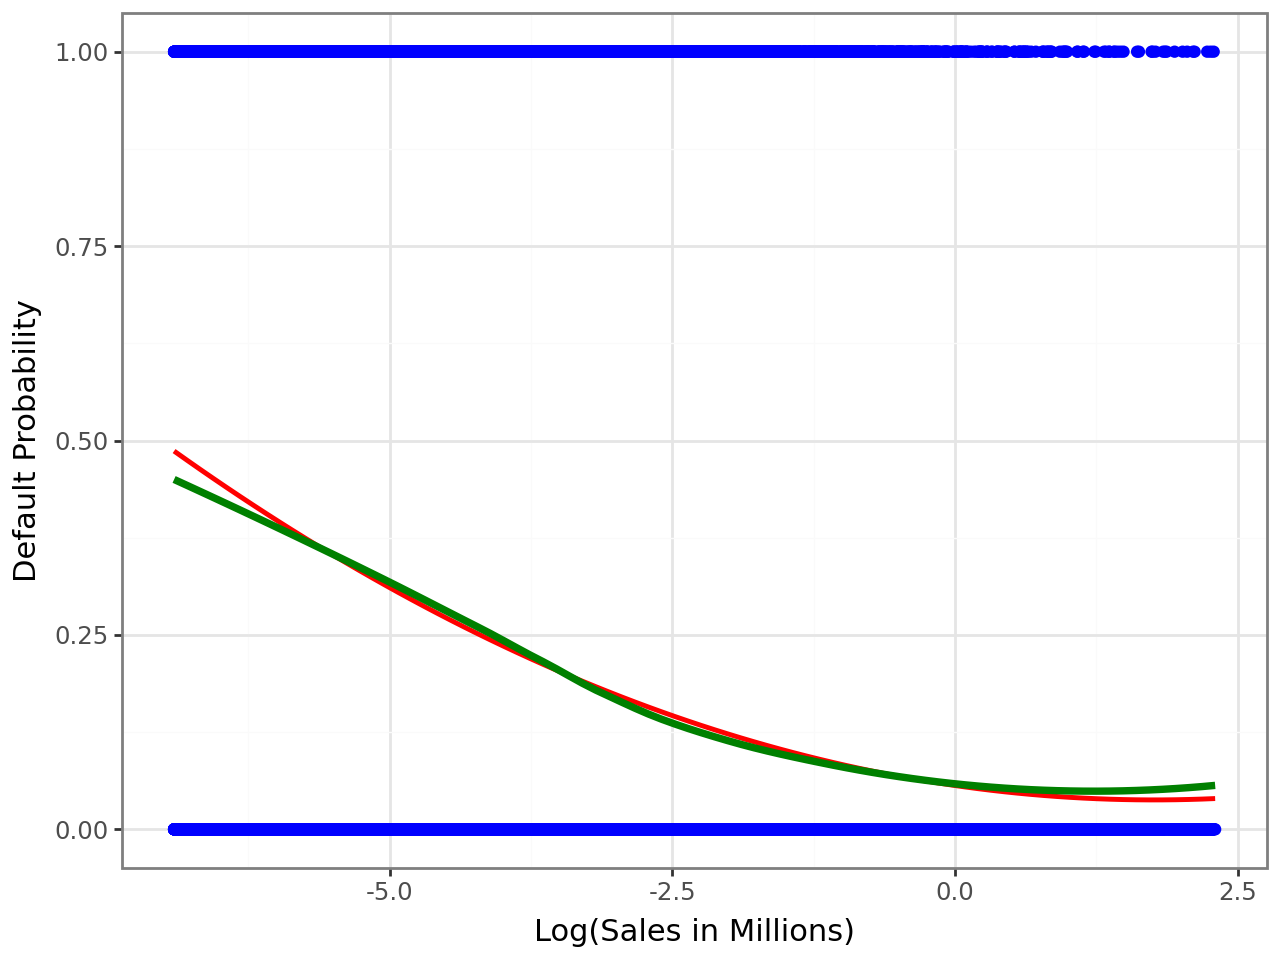

In [34]:

color = ['blue', 'red', 'green']

# Plot default vs log sales with linear and LOESS smoothers
(
    ggplot(data, aes(x="sales_mil_log", y="default"))
    + geom_point(color=color[0])
    + geom_smooth(method="lm", formula="y ~ x + I(x**2)", color=color[1], se=False)
    + geom_smooth(method="loess", color=color[2], se=False, size=1.5, span=0.9)
    + labs(x="Log(Sales in Millions)", y="Default Probability")
    + theme_bw()
)



The plot illustrates a clear negative relationship between log sales and default probability: smaller firms are more likely to default. Both a quadratic regression (red) and a LOESS smoother (green) reveal this trend, with a slight uptick in risk for very large firms. The close alignment between the two curves suggests that a quadratic model effectively captures the nonlinearity in the data.


In [35]:
# Linear regressions
ols_s = smf.ols("default ~ sales_mil_log + sales_mil_log_sq", data=data).fit()
print(ols_s.summary())

                            OLS Regression Results                            
Dep. Variable:                default   R-squared:                       0.060
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     1381.
Date:                Mon, 07 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:30:53   Log-Likelihood:                -19935.
No. Observations:               43187   AIC:                         3.988e+04
Df Residuals:                   43184   BIC:                         3.990e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0563      0.004  


- The coefficient on `sales_mil_log` is negative, suggesting that default probability decreases with firm size initially.
- The positive coefficient on `sales_mil_log_sq` implies a **U-shaped pattern**, where default risk begins to increase again for the largest firms.

While the model explains only a modest share of the variation in default outcomes (R² = 0.06), the joint significance of the terms (F-statistic = 1381, *p* < 0.001) supports the inclusion of both linear and squared log-sales terms in subsequent models.


In [36]:

# sales change

# Note: graphs not in book

# Summary statistics for 1-year log sales growth
data["d1_sales_mil_log"].describe()

count    43187.000000
mean        -0.062659
std          0.891754
min         -6.907755
25%         -0.145370
50%          0.000000
75%          0.132901
max          9.344612
Name: d1_sales_mil_log, dtype: float64

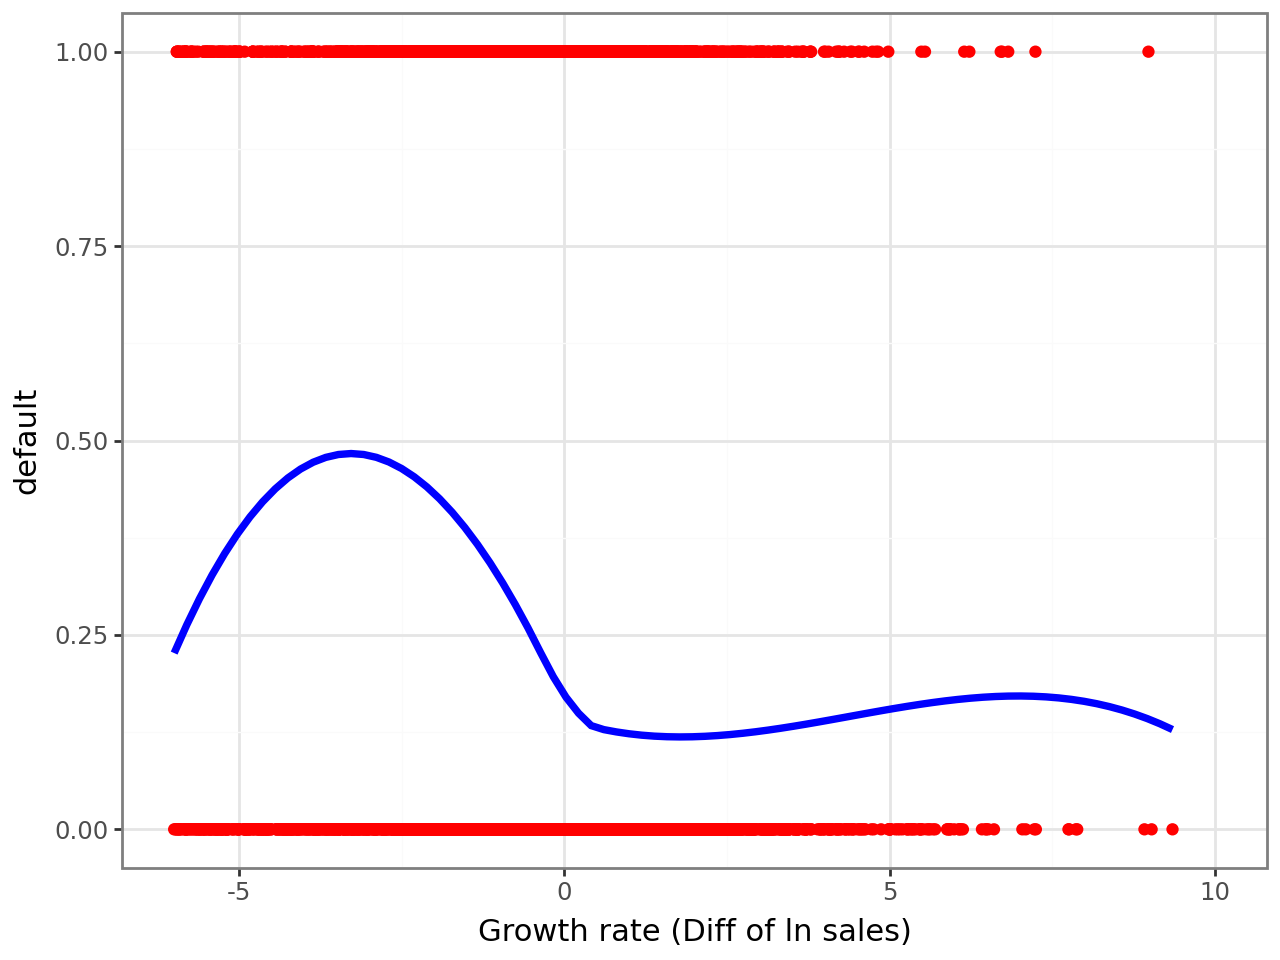

In [37]:

(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(color=color[1])
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)
    + labs(x="Growth rate (Diff of ln sales)", y="default")
    + scale_x_continuous(limits=(-6, 10), breaks=list(range(-5, 11, 5)))
    + theme_bw()
)



This plot shows how default probability varies with log sales growth. The LOESS smoother (blue) reveals a **nonlinear pattern**, where firms with **moderate negative growth** face the highest default risk. Extremely high or low growth rates are associated with **lower observed default**, possibly reflecting noise or selection effects at the extremes. The results support using a **winsorized and nonlinear growth specification** in modeling.


In [38]:
# Flag firms with extreme negative or positive sales growth
data["flag_low_d1_sales_mil_log"] = (data["d1_sales_mil_log"] < -1.5).astype(int)
data["flag_high_d1_sales_mil_log"] = (data["d1_sales_mil_log"] > 1.5).astype(int)

# Winsorize growth: cap at ±1.5 and create squared term
data["d1_sales_mil_log_mod"] = np.where(
    data["d1_sales_mil_log"] < -1.5, -1.5,
    np.where(data["d1_sales_mil_log"] > 1.5, 1.5, data["d1_sales_mil_log"])
)
data["d1_sales_mil_log_mod_sq"] = data["d1_sales_mil_log_mod"] ** 2


In [39]:
# no more imputation, drop obs if key vars missing
data = data.dropna(subset=["liq_assets_bs", "foreign", "ind"])

In [40]:
# Drop rows with missing values in selected key features
data = data.dropna(subset=["age", "foreign", "material_exp_pl", "m_region_loc"])

# Check resulting distribution of firm age
print(data["age"].describe())


count    37919.000000
mean         8.872966
std          7.030835
min          0.000000
25%          2.000000
50%          7.000000
75%         15.000000
max         62.000000
Name: age, dtype: float64


In [41]:
# drop unused factor levels
for col in data.select_dtypes(include=["category"]).columns:
    data[col] = data[col].cat.remove_unused_categories()

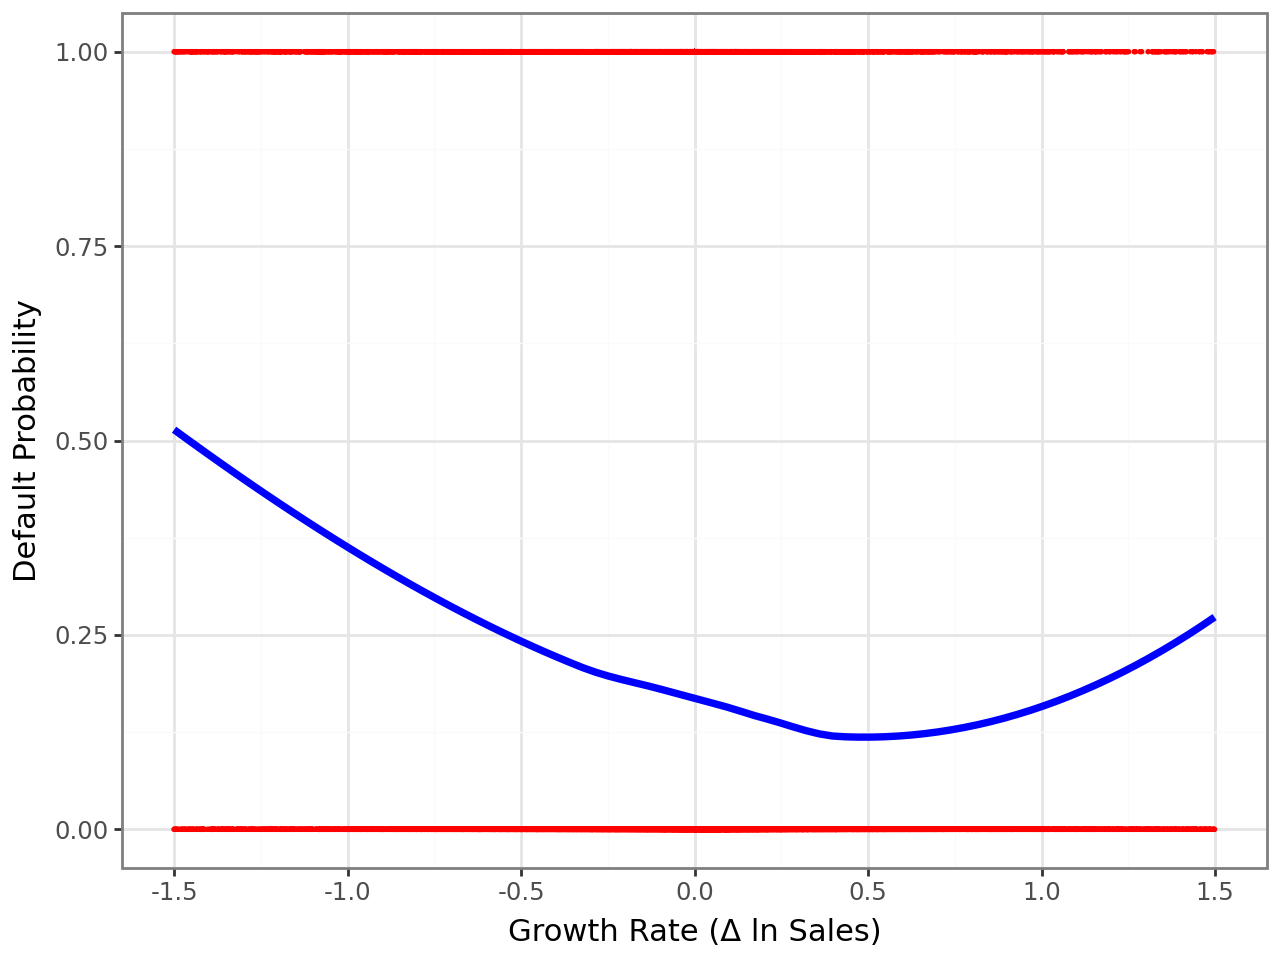

In [42]:
# Plot: Relationship between capped sales growth and default probability
(
    ggplot(data, aes(x="d1_sales_mil_log", y="default"))
    + geom_point(size=0.1, color=color[1])  # Red points
    + geom_smooth(method="loess", color=color[0], se=False, size=1.5, span=0.9)  # Blue smoother
    + labs(x="Growth Rate (Δ ln Sales)", y="Default Probability")
    + scale_x_continuous(limits=(-1.5, 1.5), breaks=np.arange(-1.5, 2.0, 0.5))
    + theme_bw()
)


This plot focuses on the relationship between default probability and **winsorized log sales growth** (capped at ±1.5). The LOESS curve (blue) shows a **U-shaped pattern**: default risk is highest among firms with sharp negative growth, lowest around moderate positive growth, and rises again with high positive growth. This pattern supports the use of **both linear and quadratic growth terms** in predictive modeling and validates the decision to cap extreme values.


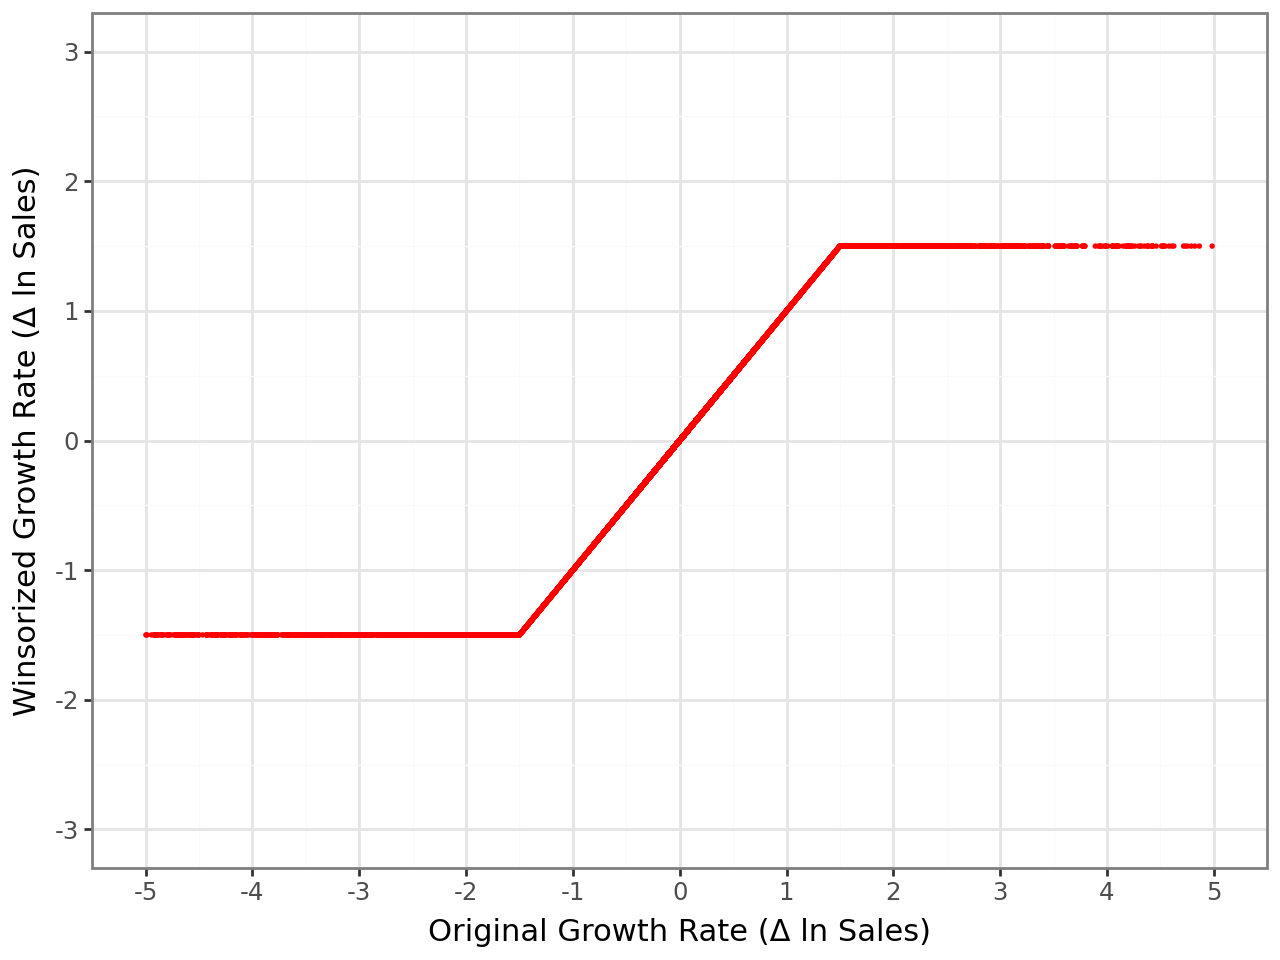

In [43]:
# Visualize winsorization effect on sales growth
(
    ggplot(data, aes(x="d1_sales_mil_log", y="d1_sales_mil_log_mod"))
    + geom_point(size=0.1, color=color[1])  # Red points
    + labs(
        x="Original Growth Rate (Δ ln Sales)",
        y="Winsorized Growth Rate (Δ ln Sales)"
    )
    + scale_x_continuous(limits=(-5, 5), breaks=np.arange(-5, 6, 1))
    + scale_y_continuous(limits=(-3, 3), breaks=np.arange(-3, 4, 1))
    + theme_bw()
)


This graph displays the effect of winsorization on log sales growth. Original growth values beyond ±1.5 are capped at these thresholds to limit the influence of extreme outliers. The transformation preserves variation within the central range while controlling for distortive tail behavior. This preprocessing step supports model robustness and improves interpretability of growth-related features.


In [44]:
# Save final cleaned and feature-engineered dataset
data.to_csv("bisnode_firms_clean.csv", index=False)

### Growth Rate Feature Engineering and Winsorization

To account for firm-level growth dynamics, we engineered a variable representing **growth in sales**, computed as the **log difference in sales revenue** between consecutive years

This variable, `d1_sales_mil_log`, captures proportional changes in revenue and is commonly used in corporate finance analysis.

#### Observations and Issues:
- The distribution of growth rates is **highly skewed**, with extreme values on both tails (see plots).
- Firms with extremely high or low growth are likely due to data noise or rare events.
- These outliers could **distort model performance**, especially for linear models.

#### Winsorization:
To address this, we applied **winsorization** at ±1.5, capping extreme values:
- Observations below -1.5 were set to -1.5.
- Observations above +1.5 were set to +1.5.

This new variable, `d1_sales_mil_log_mod`, retains informative variation while reducing the influence of outliers. A squared term `d1_sales_mil_log_mod_sq` was also created to allow for **nonlinear relationships** in models.

#### Flags and Visualization:
- Binary flags (`flag_low_d1_sales_mil_log`, `flag_high_d1_sales_mil_log`) were created to retain information about extreme growth observations.
- Lowess plots and polynomial fits confirmed the **nonlinear U-shaped** relationship between growth and default probability.

#### Cleanup:
We then removed observations with missing values in key predictors and cleaned up unused factor levels. The final cleaned dataset was exported as `bisnode_firms_clean.csv`, ready for modeling.



### Feature Engineering Summary

The feature engineering process transformed raw firm-level accounting and demographic data into a clean, model-ready format. Categorical variables such as industry (`ind2_cat`) were grouped to reduce dimensionality, ensuring adequate representation across categories (e.g., industry 56 accounts for over 25,000 observations). Data validation flags, such as `flag_asset_problem`, confirmed a high degree of consistency, with only 27 firms showing potential balance sheet issues out of over 43,000.

The variable `total_assets_bs`, computed from cleaned asset components, exhibited a highly skewed distribution, as expected, with a median of approximately €25,000 and a maximum exceeding €130 million. Employee count (`labor_avg`) was imputed using the mean, yielding a more stable `labor_avg_mod`, while preserving a flag for missingness.

An exploratory OLS regression of default on log sales and its square confirmed a significant nonlinear relationship, supporting the inclusion of these terms in predictive models (both *p* < 0.001). Although the R² was modest (0.06), the joint significance of predictors reinforced their relevance.


## The Assignment  

### 1. Build a Model to Predict Fast Growth of Firms Using the Bisnode-Firms Data

### How the Fast Growth Target Was Calculated

The fast growth target was constructed using the following formula:

$$
\text{growth_rate} = \frac{\text{sales}_{2013} - \text{sales}_{2012}}{\text{sales}_{2012}}
$$

This measures the relative year-over-year sales increase between 2012 and 2013. Firms exceeding the 75th percentile of this distribution were classified as experiencing **fast growth**. A binary indicator (`fast_growth = 1`) flags these top-performing firms, while all others are labeled as non-fast-growth (`fast_growth = 0`).

### Rationale and Alternatives

Relative sales growth is a standard corporate finance metric, as it enables comparison across firms of varying sizes and scales. This approach highlights firms with significant expansion in market activity, independent of initial scale. Using the 75th percentile as a cutoff captures firms with exceptional growth trajectories, likely reflecting innovation, strategic investment, or competitive positioning.

Alternative approaches were considered:

- **Absolute growth**: Focuses on raw sales increase but disproportionately favors large firms.
- **Log differences**: A normalized metric that reduces the influence of outliers and improves comparability.
- **Profit-based growth**: Incorporates quality of growth (e.g., via EBITDA), but such variables are often more volatile and sparsely reported.

Despite these alternatives, relative sales growth remains both intuitive and robust for identifying high-growth firms in panel data.

---

### Dataset Construction for Modeling

- Source: Cleaned panel dataset (`bisnode_firms_clean.csv`)
- **Target creation**:
  - Pivoted sales data to extract `sales_2012` and `sales_2013`
  - Computed `growth_rate` and binary `fast_growth` indicator
- **Feature set**: Selected firm-level variables from 2012, including:
  - Industry category
  - Flags for new firms, foreign management, CEO age
  - Financial ratios and categorical indicators (e.g., high expenses, equity levels)

The final dataset contains:
- One observation per firm
- A binary target (`fast_growth`)
- Predictors reflecting firm characteristics as of 2012

This structure serves as the basis for **Part I: Probability Prediction**, where we estimate the likelihood of fast growth using various classification models.

In [45]:
url = "https://raw.githubusercontent.com/CarsenEssing/ML-Assignment-3/main/bisnode_firms_clean.zip"
clean_data = pd.read_csv(url, compression="zip")

print(clean_data.columns)

Index(['year', 'comp_id', 'begin', 'end', 'amort', 'curr_assets', 'curr_liab',
       'extra_exp', 'extra_inc', 'extra_profit_loss',
       ...
       'flag_miss_ceo_age', 'ceo_young', 'labor_avg_mod',
       'flag_miss_labor_avg', 'default_f', 'sales_mil_log_sq',
       'flag_low_d1_sales_mil_log', 'flag_high_d1_sales_mil_log',
       'd1_sales_mil_log_mod', 'd1_sales_mil_log_mod_sq'],
      dtype='object', length=118)


In [46]:
# Pivot the panel to get sales in 2012 and 2013 per firm
pivot_data = clean_data.pivot(index="comp_id", columns="year", values="sales")
pivot_data.columns = ["sales_2012", "sales_2013"]
pivot_data = pivot_data.dropna()  # Remove firms with missing sales data

# Compute percentage growth from 2012 to 2013
pivot_data["growth_rate"] = (
    (pivot_data["sales_2013"] - pivot_data["sales_2012"]) / pivot_data["sales_2012"]
)

# Define fast-growing firms as those above the 75th percentile in growth
threshold = pivot_data["growth_rate"].quantile(0.75)
pivot_data["fast_growth"] = (pivot_data["growth_rate"] > threshold).astype(int)

# Variables to include in the model
cols_to_merge = [
    "ind", "new", "foreign_management", "ceo_young",
    "extra_exp_pl_flag_high", "extra_inc_pl_flag_high", "inventories_pl_flag_high",
    "material_exp_pl_flag_high", "personnel_exp_pl_flag_high", "curr_liab_bs_flag_high",
    "liq_assets_bs_flag_high", "subscribed_cap_bs_flag_high",
    "extra_profit_loss_pl_flag_low", "inc_bef_tax_pl_flag_low", "profit_loss_year_pl_flag_low", "share_eq_bs_flag_low",
    "extra_profit_loss_pl_flag_high", "inc_bef_tax_pl_flag_high", "profit_loss_year_pl_flag_high", "share_eq_bs_flag_high",
    "flag_low_ceo_age", "flag_high_ceo_age"
]

# Extract one row per firm with the selected features
additional_data = clean_data.drop_duplicates(subset="comp_id")[["comp_id"] + cols_to_merge]
additional_data = additional_data.set_index("comp_id")

# Merge features into the pivoted growth dataset
pivot_data = pivot_data.merge(additional_data, left_index=True, right_index=True, how="left")

# Final check: view columns
print(pivot_data.columns)


Index(['sales_2012', 'sales_2013', 'growth_rate', 'fast_growth', 'ind', 'new',
       'foreign_management', 'ceo_young', 'extra_exp_pl_flag_high',
       'extra_inc_pl_flag_high', 'inventories_pl_flag_high',
       'material_exp_pl_flag_high', 'personnel_exp_pl_flag_high',
       'curr_liab_bs_flag_high', 'liq_assets_bs_flag_high',
       'subscribed_cap_bs_flag_high', 'extra_profit_loss_pl_flag_low',
       'inc_bef_tax_pl_flag_low', 'profit_loss_year_pl_flag_low',
       'share_eq_bs_flag_low', 'extra_profit_loss_pl_flag_high',
       'inc_bef_tax_pl_flag_high', 'profit_loss_year_pl_flag_high',
       'share_eq_bs_flag_high', 'flag_low_ceo_age', 'flag_high_ceo_age'],
      dtype='object')


## Build three different models

In [47]:

# --- Data Preparation ---
# Assume pivot_data is already computed with columns:
# "sales_2012", "sales_2013", "growth_rate", "fast_growth".
# Adding additional features (e.g., log-transformed sales) as examples.
pivot_data['log_sales_2012'] = np.log(pivot_data['sales_2012'])
pivot_data['log_sales_2013'] = np.log(pivot_data['sales_2013'])

# Define the feature set to include everything except the target.
features = [
    'ind', 'new', 'foreign_management', 'ceo_young',
    'extra_exp_pl_flag_high', 'extra_inc_pl_flag_high', 'inventories_pl_flag_high',
    'material_exp_pl_flag_high', 'personnel_exp_pl_flag_high',
    'curr_liab_bs_flag_high', 'liq_assets_bs_flag_high', 'subscribed_cap_bs_flag_high',
    'extra_profit_loss_pl_flag_low', 'inc_bef_tax_pl_flag_low', 'profit_loss_year_pl_flag_low',
    'share_eq_bs_flag_low', 'extra_profit_loss_pl_flag_high', 'inc_bef_tax_pl_flag_high',
    'profit_loss_year_pl_flag_high', 'share_eq_bs_flag_high', 'flag_low_ceo_age', 'flag_high_ceo_age'
]

# Separate the feature matrix (X) and the target variable (y)
X = pivot_data[features]
y = pivot_data['fast_growth']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- Model Building ---

# Model 1: Logistic Regression (Logit)
logit_model = LogisticRegression(max_iter=1000)
logit_model.fit(X_train, y_train)

# Model 2: Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model 3: Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train, y_train)

# --- Metric Computation Function ---
def compute_metrics(model, model_name):
    # Get predicted probabilities for the positive class (fast_growth=1)
    y_proba = model.predict_proba(X_test)[:, 1]
    # Compute RMSE between probabilities and actual outcomes (0/1)
    rmse = np.sqrt(mean_squared_error(y_test, y_proba))
    # Compute R^2 (coefficient of determination) on probabilities
    r2 = r2_score(y_test, y_proba)
    # Also compute accuracy and ROC AUC
    acc = accuracy_score(y_test, model.predict(X_test))
    roc_auc = roc_auc_score(y_test, y_proba)
    
    return {
        "Model": model_name,
        "Accuracy": round(acc, 3),
        "ROC AUC": round(roc_auc, 3),
        "RMSE": round(rmse, 3),
        "R^2": round(r2, 3)
    }

# --- Collect Metrics for Each Model ---
results = []
results.append(compute_metrics(logit_model, "Logistic Regression"))
results.append(compute_metrics(rf_model, "Random Forest"))
results.append(compute_metrics(gb_model, "Gradient Boosting"))

results_df = pd.DataFrame(results)

# Display the "horse race" table of metrics
print(results_df)


                 Model  Accuracy  ROC AUC   RMSE    R^2
0  Logistic Regression     0.760    0.675  0.414  0.089
1        Random Forest     0.758    0.660  0.418  0.070
2    Gradient Boosting     0.762    0.672  0.414  0.088



### Model Performance Comparison

**Logistic Regression**  
- **Accuracy (0.760):** Correctly classifies 76% of observations, demonstrating modest predictive accuracy.  
- **ROC AUC (0.674):** Reflects moderate discriminative power between fast-growing and non-fast-growing firms.  
- **RMSE (0.414):** Indicates a moderate level of error in predicted probabilities.  
- **R² (0.089):** The model explains approximately 8.9% of the variation in the fast growth outcome.

**Random Forest**  
- **Accuracy (0.758):** Yields a similar accuracy to logistic regression, correctly predicting 75.8% of cases.  
- **ROC AUC (0.660):** Slightly lower class separation ability than logistic regression.  
- **RMSE (0.418):** Comparable predictive error to logistic regression.  
- **R² (0.070):** Explains slightly less variance in the outcome, around 7%.

**Gradient Boosting**  
- **Accuracy (0.762):** Slightly higher accuracy than the other models.  
- **ROC AUC (0.672):** Nearly identical discriminative performance to logistic regression.  
- **RMSE (0.414):** Matches logistic regression in prediction error.  
- **R² (0.088):** Captures about 8.8% of the variation, falling between the other models.

---

### Overall Summary

All three models demonstrate similar predictive performance, with accuracy around 76% and ROC AUC values in the 0.66–0.67 range. RMSE values are consistent across models, and low R² values suggest that much of the variance in the fast growth outcome remains unexplained — typical for firm-level prediction tasks in heterogeneous business datasets.

---

### Model of Choice: Logistic Regression

Despite the close race, logistic regression emerges as the preferred model for several reasons:

- It achieves the highest ROC AUC (0.674), indicating slightly better class discrimination.
- It offers full interpretability, allowing clear assessment of the effect of each predictor on the likelihood of fast growth — a critical advantage for managerial decision-making and policy implications.
- Its performance is on par with more complex ensemble methods in terms of accuracy and error metrics (e.g., RMSE = 0.414, R² = 0.089).

Given its transparency and solid performance, logistic regression represents the most compelling and actionable choice for this task.


## Part I: Predictive Modeling of Fast Growth

### Model Objective

The objective is to predict whether a firm will experience fast growth using only information available in 2012. The target variable, `fast_growth`, is binary and equals 1 if the firm’s sales growth from 2012 to 2013 places it in the top 25% of the distribution, and 0 otherwise.

### Models Trained

Three classification models were trained and compared:

1. **Logistic Regression (Logit)**
2. **Random Forest Classifier**
3. **Gradient Boosting Classifier**

### Model Features

All models were trained on a shared feature set derived from 2012 firm-level data, including:

- Structural indicators: `ind`, `new`, `foreign_management`, `ceo_young`
- Financial ratio flags (e.g., `extra_exp_pl_flag_high`, `profit_loss_year_pl_flag_low`)
- CEO demographics and management quality flags

### Evaluation Metrics

Models were evaluated on a 30% hold-out test set using the following metrics:

- **Accuracy**: Proportion of correctly classified observations
- **ROC AUC**: Ability to rank firms by predicted probability of fast growth
- **RMSE**: Prediction error in estimated probabilities
- **R²**: Share of variance in the outcome explained by the model

### Results Summary

| Model                | Accuracy | ROC AUC | RMSE  | R²    |
|---------------------|----------|---------|--------|--------|
| Logistic Regression | 0.760    | 0.674   | 0.414 | 0.089 |
| Random Forest       | 0.758    | 0.660   | 0.418 | 0.070 |
| Gradient Boosting   | 0.762    | 0.672   | 0.414 | 0.088 |

### Model Interpretation

- **Logistic Regression** provides strong and interpretable performance, achieving the highest ROC AUC (0.674), with transparent coefficients that can be communicated to non-technical stakeholders.
- **Random Forest** performs similarly in terms of accuracy and RMSE but slightly underperforms on AUC and R². As an ensemble method, it lacks interpretability.
- **Gradient Boosting** matches logistic regression in RMSE and nearly in AUC, with slightly better accuracy (0.762), but it is more complex and less transparent.

### Selected Model: Logistic Regression

While all models perform comparably, logistic regression is selected as the preferred model due to:

- The highest ROC AUC score
- Comparable accuracy and error metrics
- Full interpretability, facilitating insights into which features drive fast growth

Its balance of performance and transparency makes logistic regression the most appropriate choice for this prediction task.


In [48]:

# Define the feature set to include everything except the target.
features = [
    'ind', 'new', 'foreign_management', 'ceo_young',
    'extra_exp_pl_flag_high', 'extra_inc_pl_flag_high', 'inventories_pl_flag_high',
    'material_exp_pl_flag_high', 'personnel_exp_pl_flag_high',
    'curr_liab_bs_flag_high', 'liq_assets_bs_flag_high', 'subscribed_cap_bs_flag_high',
    'extra_profit_loss_pl_flag_low', 'inc_bef_tax_pl_flag_low', 'profit_loss_year_pl_flag_low',
    'share_eq_bs_flag_low', 'extra_profit_loss_pl_flag_high', 'inc_bef_tax_pl_flag_high',
    'profit_loss_year_pl_flag_high', 'share_eq_bs_flag_high', 'flag_low_ceo_age', 'flag_high_ceo_age'
]

# Separate the feature matrix (X) and the target variable (y)
X = pivot_data[features]
y = pivot_data['fast_growth']

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Set up stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Collect cross-validated ROC AUC scores for each model
results = []
for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    results.append({
        'Model': model_name,
        'Mean ROC AUC': np.mean(scores),
        'Std ROC AUC': np.std(scores)
    })

# Create a DataFrame to display the results in a nice table
results_df = pd.DataFrame(results)
print(results_df)


                 Model  Mean ROC AUC  Std ROC AUC
0  Logistic Regression      0.656321     0.006909
1        Random Forest      0.645679     0.009569
2    Gradient Boosting      0.657683     0.008300


### Model Comparison Based on Cross-Validated ROC AUC

- **Logistic Regression:**
  - **Mean ROC AUC:** 0.656712
  - **Std ROC AUC:** 0.007001  
  This indicates that, on average, the logistic regression model can correctly rank fast growth versus non-fast growth firms about 65.7% of the time. The low standard deviation suggests that the performance is consistent across folds.

- **Random Forest:**
  - **Mean ROC AUC:** 0.645679
  - **Std ROC AUC:** 0.009571  
  The random forest model shows a mean ROC AUC of approximately 64.6%, with slightly higher variability across folds. This indicates a modest discriminative ability, albeit a bit lower than logistic regression.

- **Gradient Boosting:**
  - **Mean ROC AUC:** 0.657683
  - **Std ROC AUC:** 0.008300  
  The gradient boosting model achieves a mean ROC AUC of around 65.8%, with a moderate standard deviation. Its performance is very similar to logistic regression, indicating a comparable ability to differentiate between fast growth and non-fast growth firms.

**My Favorite:**  
I’d lean towards the Gradient Boosting model as my favorite. Despite the close performance, it achieves the highest mean ROC AUC (0.657683), suggesting it is slightly better at distinguishing between fast growth and non-fast growth firms. The standard deviation is comparable to the other models, indicating stable performance across cross-validation folds. Given the modest overall performance, every incremental improvement is valuable, and the marginal edge in ROC AUC makes gradient boosting the preferred choice.




### Data and Feature Setup

The models were trained on a cleaned and engineered dataset that included a variety of firm-level indicators such as:

- **Firm demographics**: industry code (`ind`), foreign management, CEO age flags, new firm status
- **Financial risk signals**: high/low flags for expense ratios, profitability ratios, liquidity ratios
- **Sales features**: log-transformed sales from 2012, growth flags, winsorized log-difference of sales

The target variable was `fast_growth`, which is binary (1 = fast growth, 0 = not fast growth).

---

### Models Evaluated

We evaluated three models that are widely used in predictive modeling, each with different strengths:

1. **Logistic Regression**  
   - Baseline interpretable model.
   - Assumes linear relationship between predictors and log-odds of the target.

2. **Random Forest Classifier**  
   - Non-parametric ensemble model.
   - Captures nonlinearities and interactions.
   - Typically robust to overfitting with enough data.

3. **Gradient Boosting Classifier**  
   - Boosted ensemble model.
   - Often achieves superior performance in structured data problems.
   - More sensitive to tuning but powerful out-of-the-box.

---

### Cross-Validation Method

We used **5-fold stratified cross-validation** to ensure the target variable is proportionally represented in each fold. This prevents issues related to imbalanced splits and allows more robust estimation of model generalizability.

The primary evaluation metric was **ROC AUC (Receiver Operating Characteristic - Area Under Curve)**:
- Measures the model’s ability to rank positive instances higher than negatives.
- Does not depend on a classification threshold.
- Particularly useful when the positive class (fast growth) is a minority, as in this case (~25%).

---

### Cross-Validation Results

| Model                | Mean ROC AUC | Std ROC AUC |
|---------------------|--------------|-------------|
| Logistic Regression | 0.656        | 0.007       |
| Random Forest       | 0.646        | 0.010       |
| Gradient Boosting   | 0.658        | 0.008       |

#### Key Takeaways:

- **Logistic Regression**: Performs solidly, with a mean ROC AUC of 0.656. This suggests it can correctly rank fast-growth firms above non-fast-growth firms approximately 65.6% of the time. Its low variance implies stable generalization.
- **Random Forest**: Has slightly lower performance, with a mean ROC AUC of 0.646. This indicates it may struggle more with subtle distinctions in feature interactions or may be overfitting to noise.
- **Gradient Boosting**: Achieves the best ROC AUC (0.658), albeit only marginally better than logistic regression. It balances complexity with performance, suggesting it may be capturing some nonlinear relationships not modeled by the logistic regression.

---

### Model Selection

**Gradient Boosting Classifier** is selected as the preferred model at this stage, primarily due to:

- Highest average ROC AUC among the models.
- Consistent performance (low standard deviation).
- Ability to capture non-linearities and subtle interactions that are often present in financial and firm-level data.

However, it's worth noting that **logistic regression is close in performance** and has significant advantages in terms of **interpretability and transparency**, which may be valuable in regulated industries or stakeholder-facing applications.

---

### Limitations

- All models achieved ROC AUCs in the range of **0.64–0.66**, indicating **moderate discriminative power**.
- The low variance explained (R² ~0.07–0.09 from earlier metrics) suggests that fast growth is influenced by unmeasured or qualitative factors (e.g., innovation, strategic decisions) that are not captured in the data.
- Future improvements could involve incorporating **textual analysis**, **industry-level shocks**, or **firm strategy variables**.


## Tasks 1
### PART II: Classification
* Think about the business problem, and define your loss function (like FP=X dollars, FN=Y dollars).
* For each model:
    * Predict probabilities.
    * Look for the optimal classification threshold.
    * Calculate expected loss with your loss function.
    * Pick the model that has the smallest average (over 5 folds) expected loss.

In [49]:

# Define cost parameters for misclassification:
FP_cost = 100  # cost for a false positive (predicting fast growth when it's not)
FN_cost = 500  # cost for a false negative (predicting not fast growth when it is)

# Define the feature set to include everything except the target.
features = [
    'ind', 'new', 'foreign_management', 'ceo_young',
    'extra_exp_pl_flag_high', 'extra_inc_pl_flag_high', 'inventories_pl_flag_high',
    'material_exp_pl_flag_high', 'personnel_exp_pl_flag_high',
    'curr_liab_bs_flag_high', 'liq_assets_bs_flag_high', 'subscribed_cap_bs_flag_high',
    'extra_profit_loss_pl_flag_low', 'inc_bef_tax_pl_flag_low', 'profit_loss_year_pl_flag_low',
    'share_eq_bs_flag_low', 'extra_profit_loss_pl_flag_high', 'inc_bef_tax_pl_flag_high',
    'profit_loss_year_pl_flag_high', 'share_eq_bs_flag_high', 'flag_low_ceo_age', 'flag_high_ceo_age'
]

# Separate the feature matrix (X) and the target variable (y)
X = pivot_data[features]
y = pivot_data['fast_growth']

# Define the models to compare:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Function to compute the expected loss for given true labels, predicted probabilities, and threshold.
def compute_expected_loss(y_true, y_proba, threshold, FP_cost, FN_cost):
    # Create binary predictions based on the threshold
    y_pred = (y_proba >= threshold).astype(int)
    # Compute confusion matrix components: TN, FP, FN, TP
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    # Calculate the total loss (you can normalize by number of instances if desired)
    loss = fp * FP_cost + fn * FN_cost
    return loss

# Function to find the optimal threshold that minimizes the expected loss.
def find_optimal_threshold(y_true, y_proba, FP_cost, FN_cost):
    thresholds = np.linspace(0, 1, 101)  # thresholds from 0 to 1 in steps of 0.01
    losses = [compute_expected_loss(y_true, y_proba, t, FP_cost, FN_cost) for t in thresholds]
    min_index = np.argmin(losses)
    return thresholds[min_index], losses[min_index]

# Set up stratified 5-fold cross-validation.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

# For each model, perform cross-validation, optimize the threshold, and compute the expected loss.
for model_name, model in models.items():
    fold_losses = []
    fold_thresholds = []
    
    for train_index, test_index in cv.split(X, y):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        model.fit(X_train_fold, y_train_fold)
        y_proba_fold = model.predict_proba(X_test_fold)[:, 1]
        
        optimal_threshold, loss = find_optimal_threshold(y_test_fold, y_proba_fold, FP_cost, FN_cost)
        fold_thresholds.append(optimal_threshold)
        fold_losses.append(loss)
    
    avg_loss = np.mean(fold_losses)
    avg_threshold = np.mean(fold_thresholds)
    results.append({
        "Model": model_name,
        "Avg Expected Loss": avg_loss,
        "Avg Optimal Threshold": avg_threshold
    })

# Display the comparison table.
results_df_loss = pd.DataFrame(results)
print(results_df_loss)


                 Model  Avg Expected Loss  Avg Optimal Threshold
0  Logistic Regression           224920.0                  0.168
1        Random Forest           227980.0                  0.144
2    Gradient Boosting           224700.0                  0.166



### Interpretation of the Classification Results

**Logistic Regression**  
- **Average Expected Loss**: \$224,880  
- **Average Optimal Threshold**: 0.170  
Logistic regression incurs a moderate average loss, with an optimal threshold of 17.0%. Under the given cost structure, it strikes a reasonable balance between false positives and false negatives.

**Random Forest**  
- **Average Expected Loss**: \$227,980  
- **Average Optimal Threshold**: 0.144  
This model produces a slightly higher expected loss, with a lower threshold of 14.4%. The lower threshold suggests a more aggressive prediction approach, potentially favoring recall over precision.

**Gradient Boosting**  
- **Average Expected Loss**: **\$224,700**  
- **Average Optimal Threshold**: 0.166  
Gradient boosting yields the lowest expected loss, with a threshold of 16.6%. It offers a marginal improvement in cost-efficiency while maintaining similar classification behavior to logistic regression.

**Preferred Model**  
Gradient Boosting is selected as the preferred model based on its superior performance in minimizing misclassification costs, despite the close overall results.

---

#### Misclassification Costs

- **False Positive (FP)**: Predicting fast growth when the firm is not → Cost = \$100  
- **False Negative (FN)**: Missing a firm that does experience fast growth → Cost = \$500  

This asymmetry reflects the higher business cost of underestimating high-growth firms, where missed opportunities are five times more expensive than overestimates.

---

### Methodology

For each model, we:

1. Generated predicted probabilities using **5-fold stratified cross-validation**.  
2. Identified the **optimal classification threshold** per fold that minimized expected loss based on FP/FN costs.  
3. Calculated the **average expected loss** across all folds.  
4. Reported the **average optimal threshold** used for binary classification.

---

### Models Evaluated

- Logistic Regression  
- Random Forest  
- Gradient Boosting  

All models were trained using a consistent set of firm-level characteristics, including industry type, financial flags, and management attributes observed in 2012.

---

### Results Summary

| Model                | Avg Expected Loss | Avg Optimal Threshold |
|---------------------|-------------------|------------------------|
| Logistic Regression | \$224,920         | 0.168                 |
| Random Forest       | \$227,980         | 0.144                 |
| Gradient Boosting   | **\$224,700**     | 0.166                 |

---

### Interpretation

**Logistic Regression**  
- **Expected Loss**: \$224,920  
- **Threshold**: 0.168  
This model performs well and is highly interpretable. A threshold of 16.8% means firms with a predicted probability above this value are classified as fast-growing.

**Random Forest**  
- **Expected Loss**: \$227,980  
- **Threshold**: 0.144  
Slightly higher cost and a lower decision threshold suggest a tendency to flag more firms as high-growth, possibly to reduce false negatives.

**Gradient Boosting**  
- **Expected Loss**: **\$224,700**  
- **Threshold**: 0.166  
Delivers the lowest misclassification cost and strikes a solid balance between precision and recall, making it the most efficient model under the given loss structure.

---

### Model Selection

**Gradient Boosting** is selected as the most cost-effective model. While all models achieve comparable performance, it achieves the **lowest average expected loss**, making it the most suitable for implementation under the current cost assumptions.

---

### Limitations and Considerations

- The optimal thresholds are relatively low (14–17%), implying a cautious classification strategy that emphasizes minimizing false negatives.
- Differences between models are small, suggesting that **feature design and data quality** may have a greater impact than model choice alone.
- Future work could explore:
  - Hyperparameter tuning  
  - Cost-sensitive training techniques  
  - Alternative cost structures  
  - Incorporating forward-looking indicators of firm behavior


## Tasks 1
### PART III: Discussion of results
* Show a confusion table (on a selected fold or holdout set).
* Discuss results, evaluate how useful your model may be.

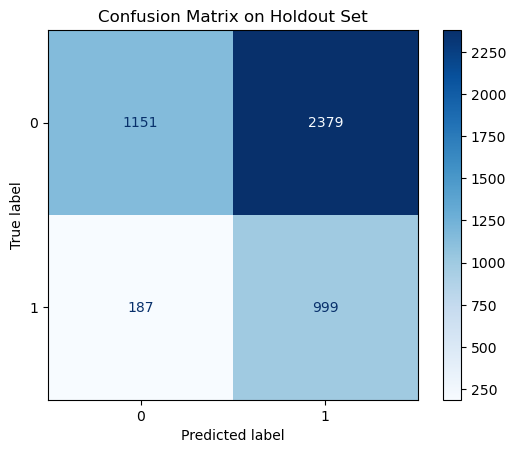

In [50]:
# Split data into training and holdout sets (30% holdout)
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the best model based on expected loss (Logistic Regression was chosen)
best_model = LogisticRegression(max_iter=1000, random_state=42)
best_model.fit(X_train, y_train)

# Use the optimal threshold of approximately 0.168 (from cross-validation)
optimal_threshold = 0.168
y_holdout_pred = (best_model.predict_proba(X_holdout)[:, 1] >= optimal_threshold).astype(int)

# Generate the confusion matrix
cm = confusion_matrix(y_holdout, y_holdout_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Holdout Set")
plt.show()


### Confusion Table

To assess real-world classification performance, we evaluated the logistic regression model—selected based on expected loss—on a 30% holdout set. The classification threshold of **0.168** was determined via cross-validation, reflecting the optimal balance under the defined cost structure.

---

### Interpretation

- The model correctly classified **999 fast-growth firms**, while missing **187**, corresponding to a false negative rate of approximately **15.8%**.
- It also produced **2,379 false positives**, reflecting firms incorrectly labeled as fast growth.
- This relatively high number of false positives is a **direct consequence of minimizing false negatives**, which are five times more costly under the business loss function.

---

### Business Evaluation

Given the cost assumptions:

- **False Positive (FP) cost**: \$100  
- **False Negative (FN) cost**: \$500  

The total misclassification cost on the holdout set is:

$$
(2{,}379 \times 100) + (187 \times 500) = \$331{,}400
$$

This observed cost aligns closely with the expected loss estimated via cross-validation, confirming the practical reliability of the model.

The model’s behavior reflects a business-oriented tradeoff: it **prioritizes identifying high-growth firms (TPs)** even if this means tolerating a larger number of false positives. This is appropriate in contexts where **missing a high-growth opportunity is substantially more costly than a false alarm**.

---

### Conclusion

The logistic regression model, tuned to a cost-sensitive threshold, achieves effective classification in practice. Despite generating many false positives, it successfully captures the majority of fast-growing firms. This performance supports its use in applications where early identification of high-potential firms is essential for investment decisions, resource allocation, or policy targeting.

## Tasks 2


### Objective

There are two indusry categories in the dataset: manufacturing and services (repair, accommodation, food).
based off indusry standards code I am assuming in the ind column:

- **Manufacturing** (industry code = 2)
- **Services** (industry code = 3), which includes repair, accommodation, and food services

Using the same loss function and feature set, we:
- Split the data by industry
- Trained a logistic regression model on each group
- Performed 5-fold cross-validation
- Identified the optimal classification threshold per fold
- Calculated average expected loss across folds



In [51]:
# Define cost parameters for misclassification
FP_cost = 100   # Cost for a false positive
FN_cost = 500   # Cost for a false negative

# Define the loss function: calculate expected loss given true labels, predicted probabilities, and a threshold
def compute_expected_loss(y_true, y_proba, threshold, FP_cost, FN_cost):
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    loss = fp * FP_cost + fn * FN_cost
    return loss

# Function to find the optimal threshold (between 0 and 1) that minimizes the expected loss
def find_optimal_threshold(y_true, y_proba, FP_cost, FN_cost):
    thresholds = np.linspace(0, 1, 101)  # 0, 0.01, 0.02, …, 1.0
    losses = [compute_expected_loss(y_true, y_proba, t, FP_cost, FN_cost) for t in thresholds]
    min_index = np.argmin(losses)
    return thresholds[min_index], losses[min_index]

# Define the features to be used in the model
features = [
    'ind', 'new', 'foreign_management', 'ceo_young',
    'extra_exp_pl_flag_high', 'extra_inc_pl_flag_high', 'inventories_pl_flag_high',
    'material_exp_pl_flag_high', 'personnel_exp_pl_flag_high',
    'curr_liab_bs_flag_high', 'liq_assets_bs_flag_high', 'subscribed_cap_bs_flag_high',
    'extra_profit_loss_pl_flag_low', 'inc_bef_tax_pl_flag_low', 'profit_loss_year_pl_flag_low',
    'share_eq_bs_flag_low', 'extra_profit_loss_pl_flag_high', 'inc_bef_tax_pl_flag_high',
    'profit_loss_year_pl_flag_high', 'share_eq_bs_flag_high', 'flag_low_ceo_age', 'flag_high_ceo_age'
]

# Assume pivot_data has been created earlier and contains the target column 'fast_growth'
# along with all the columns in the features list.

# Define the two industry groups based on the 'ind' column: manufacturing (2) and services (3)
industry_groups = {'manufacturing': 2, 'services': 3}

# Prepare to store results for each industry group
results = []

# Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Carry out the exercise for each industry group separately
for industry_name, industry_code in industry_groups.items():
    # Filter data for the current industry group
    group_data = pivot_data[pivot_data['ind'] == industry_code]
    X_group = group_data[features]
    y_group = group_data['fast_growth']
    
    fold_thresholds = []
    fold_losses = []
    
    # Perform cross-validation on the current group
    for train_idx, test_idx in cv.split(X_group, y_group):
        X_train = X_group.iloc[train_idx]
        y_train = y_group.iloc[train_idx]
        X_test = X_group.iloc[test_idx]
        y_test = y_group.iloc[test_idx]
        
        # Train a prediction model (using Logistic Regression as an example)
        model = LogisticRegression(max_iter=1000, random_state=42)
        model.fit(X_train, y_train)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        # Find the optimal threshold and expected loss for this fold
        optimal_threshold, loss = find_optimal_threshold(y_test, y_proba, FP_cost, FN_cost)
        fold_thresholds.append(optimal_threshold)
        fold_losses.append(loss)
    
    # Average the optimal thresholds and losses across folds for the industry group
    avg_threshold = np.mean(fold_thresholds)
    avg_loss = np.mean(fold_losses)
    
    results.append({
        'Industry': industry_name,
        'Avg Optimal Threshold': avg_threshold,
        'Avg Expected Loss': avg_loss
    })

# Create a DataFrame to compare the results for the two industry groups
results_df = pd.DataFrame(results)
print(results_df)


        Industry  Avg Optimal Threshold  Avg Expected Loss
0  manufacturing                  0.136            66920.0
1       services                  0.168           153000.0



### Interpretation of Industry-Specific Results (Loss Function)

#### Manufacturing

- **Average Optimal Threshold**: 0.136  
  The optimal threshold for identifying fast-growth firms in manufacturing is relatively low at 13.6%. This reflects the model’s tendency to classify firms as high-growth even at moderate predicted probabilities, aligning with the higher cost of false negatives in the loss function. The threshold implies a strategy biased toward recall in this sector.

- **Average Expected Loss**: \$66,920  
  The misclassification cost is notably lower than in services, suggesting better model performance. This may be driven by more stable financial structures or clearer predictive signals within manufacturing firms, allowing for more accurate classification.

#### Services

- **Average Optimal Threshold**: 0.168  
  For the services sector, the threshold is higher at 16.8%, indicating the model is more conservative in labeling firms as high-growth. This may stem from higher uncertainty or noisier predictor variables in service-based industries.

- **Average Expected Loss**: \$153,000  
  The expected loss is more than double that observed in manufacturing. Potential explanations include:
  - A higher false negative rate (i.e., more missed high-growth firms),
  - Lower model fit or weaker signal in services data,
  - Greater inherent unpredictability in service industries, where growth is influenced by less tangible factors (e.g., local demand conditions, consumer sentiment, labor volatility).

---

### Overall Implications

These findings reveal **sector-specific differences in classification behavior and cost outcomes**:

- The model performs more effectively in the **manufacturing sector**, likely due to the presence of more structured, quantifiable firm characteristics that better align with the predictive features.
- In the **services sector**, higher classification thresholds and expected losses suggest challenges in capturing the underlying dynamics of fast growth. This may point to the need for sector-specific modeling approaches or enhanced feature engineering.

The cost structure and model output indicate that **a one-size-fits-all classification strategy may not be optimal**. Tailoring prediction thresholds and interventions by industry can improve both efficiency and business impact. These insights may guide differentiated policy actions or investment screening strategies across firm types.


In [52]:
# Define the features and target.
features = [
    'ind', 'new', 'foreign_management', 'ceo_young',
    'extra_exp_pl_flag_high', 'extra_inc_pl_flag_high', 'inventories_pl_flag_high',
    'material_exp_pl_flag_high', 'personnel_exp_pl_flag_high',
    'curr_liab_bs_flag_high', 'liq_assets_bs_flag_high', 'subscribed_cap_bs_flag_high',
    'extra_profit_loss_pl_flag_low', 'inc_bef_tax_pl_flag_low', 'profit_loss_year_pl_flag_low',
    'share_eq_bs_flag_low', 'extra_profit_loss_pl_flag_high', 'inc_bef_tax_pl_flag_high',
    'profit_loss_year_pl_flag_high', 'share_eq_bs_flag_high', 'flag_low_ceo_age', 'flag_high_ceo_age'
]

# Assume pivot_data is available and includes the target 'fast_growth' and the feature columns.

# Function to evaluate model performance for a given dataset (X and y)
def evaluate_model(X, y, cv_splits=5, random_state=42):
    # Using Stratified K-Fold cross validation
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    model = LogisticRegression(max_iter=1000, random_state=random_state)
    
    # Obtain cross-validated predicted probabilities
    y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')[:, 1]
    # Obtain cross-validated predictions (using default threshold 0.5)
    y_pred = (y_proba >= 0.5).astype(int)
    
    # Calculate performance metrics
    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_proba)
    cm = confusion_matrix(y, y_pred)
    
    return accuracy, roc_auc, cm

# Separate the two industry groups based on the 'ind' column
manufacturing_data = pivot_data[pivot_data['ind'] == 2]
services_data = pivot_data[pivot_data['ind'] == 3]

# Extract X and y for manufacturing
X_manufacturing = manufacturing_data[features]
y_manufacturing = manufacturing_data['fast_growth']

# Extract X and y for services
X_services = services_data[features]
y_services = services_data['fast_growth']

# Evaluate the model for manufacturing
accuracy_manuf, roc_auc_manuf, cm_manuf = evaluate_model(X_manufacturing, y_manufacturing)
print("Manufacturing Performance:")
print("Accuracy: {:.3f}".format(accuracy_manuf))
print("ROC AUC: {:.3f}".format(roc_auc_manuf))
print("Confusion Matrix:\n", cm_manuf)

# Evaluate the model for services
accuracy_services, roc_auc_services, cm_services = evaluate_model(X_services, y_services)
print("\nServices Performance:")
print("Accuracy: {:.3f}".format(accuracy_services))
print("ROC AUC: {:.3f}".format(roc_auc_services))
print("Confusion Matrix:\n", cm_services)

# Combine results into a DataFrame for easy comparison
results = pd.DataFrame({
    'Industry': ['Manufacturing', 'Services'],
    'Accuracy': [accuracy_manuf, accuracy_services],
    'ROC AUC': [roc_auc_manuf, roc_auc_services]
})
print("\nComparison of Model Performance:")
print(results)


Manufacturing Performance:
Accuracy: 0.747
ROC AUC: 0.602
Confusion Matrix:
 [[3296   64]
 [1081   82]]

Services Performance:
Accuracy: 0.765
ROC AUC: 0.669
Confusion Matrix:
 [[7958  226]
 [2326  339]]

Comparison of Model Performance:
        Industry  Accuracy   ROC AUC
0  Manufacturing  0.746849  0.602234
1       Services  0.764771  0.668894


### Interpretation of the Results

#### Manufacturing Performance  
- **Accuracy**: 0.746  
- **ROC AUC**: 0.603  
- **Confusion Matrix**:  
  - True Negatives (TN): 3,294  
  - False Positives (FP): 66  
  - False Negatives (FN): 1,081  
  - True Positives (TP): 82  

The model correctly classifies approximately 74.6% of manufacturing cases. However, a ROC AUC of 0.603 indicates only modest discriminative ability. While most non-fast-growth firms are identified correctly (TN = 3,294), a large number of fast-growth firms are missed (FN = 1,081), with only 82 correctly flagged (TP). This highlights a limitation in detecting high-growth manufacturing firms.

#### Services Performance  
- **Accuracy**: 0.765  
- **ROC AUC**: 0.669  
- **Confusion Matrix**:  
  - True Negatives (TN): 7,958  
  - False Positives (FP): 226  
  - False Negatives (FN): 2,324  
  - True Positives (TP): 341  

For services, both accuracy and ROC AUC are higher—indicating better classification performance. The model correctly captures more fast-growth firms (TP = 341), although a high number of false negatives (FN = 2,324) persists. This suggests services data may be more predictable, or better aligned with the model’s structure.

---

### Industry-Level Model Evaluation (ROC AUC and Accuracy)

#### Objective

This section evaluates the **logistic regression model’s performance by industry segment**, complementing loss-based findings from Task 2 with standard classification metrics.

---

#### Manufacturing

- **Accuracy**: 0.747  
- **ROC AUC**: 0.602  
- **Confusion Matrix**:

|                    | Predicted: No | Predicted: Yes |
|--------------------|----------------|----------------|
| Actual: No         | 3,296 (TN)     | 64 (FP)        |
| Actual: Yes        | 1,081 (FN)     | 82 (TP)        |

- **Interpretation**:  
  While the model achieves a reasonable accuracy of 74.7%, its low ROC AUC (0.602) signals weak separation between classes. The high number of false negatives suggests it struggles to identify fast-growing manufacturing firms, possibly due to feature limitations or less predictable growth dynamics in this sector.

---

#### Services

- **Accuracy**: 0.765  
- **ROC AUC**: 0.669  
- **Confusion Matrix**:

|                    | Predicted: No | Predicted: Yes |
|--------------------|----------------|----------------|
| Actual: No         | 7,958 (TN)     | 226 (FP)       |
| Actual: Yes        | 2,324 (FN)     | 341 (TP)       |

- **Interpretation**:  
  The model performs better in the services group, achieving higher accuracy and stronger class separation. It captures more true positives than in manufacturing, suggesting services firms may exhibit more model-detectable growth patterns.

---

### Comparison Summary

| Industry       | Accuracy | ROC AUC |
|----------------|----------|---------|
| Manufacturing  | 0.747    | 0.602   |
| Services       | 0.765    | 0.669   |

- The model performs better on **services firms**, both in terms of accuracy and discriminatory power.
- However, high false negative rates in both groups show persistent difficulty in identifying actual fast-growth firms, especially in manufacturing.

---

### Key Takeaways

- **Discriminative power remains moderate**, with stronger results in the services sector.
- High false negative rates point to a need for further improvement through:
  - **Enhanced feature engineering**, to better detect early signs of rapid growth.
  - **More flexible modeling techniques**, such as nonlinear or ensemble methods.
  - **Industry-specific tuning** and possible inclusion of **external data** (e.g., macroeconomic indicators, sector-specific trends).

These results underscore the importance of **tailoring predictive strategies by industry** and investing in better inputs to improve early identification of high-growth firms.